### 自适应线性神经网络

和感知机不同的是，自适应线性神经网络的激励函数是连续的，而不是像感知机里面那样是阶跃的，这样的一个好处是，它的代价函数是可导的。

而且代价函数 $J(w) = \frac{1}{2}\sum_{i}(y^{(i)} - \phi(z^{(i)}))^2$ 也是一个凸函数，因此可以通过简单，高效的梯度下降算法进行优化。

梯度下降算法：$$w := w + \Delta w \\ \Delta w = -\alpha \Delta J(w)$$

### 代码实现

In [1]:
class AdalineGD(object):
    """ADAptive LInear NEuron classifier
    Parameters
    --------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    
    Attributes
    --------------
    w_ : id-array
        weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    """
    def __init__(self, eta=0.01, n_iter=50):
        self.eta = eta
        self.n_iter = n_iter
    
    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            # 这里省略了样本的数量
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors ** 2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        """这里的激活函数是一个恒等函数"""
        return self.net_input(X)
    
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

### 训练以及可视化

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv("iris.data", header = None)

# 取出数据中的分类信息
y = df.iloc[0:100, 4].values
# 讲这些信息用离散化数据表示
y = np.where(y == "Iris-setosa", -1, 1)

# 取出我们需要的特征信息
X = df.iloc[0:100, [0, 2]].values

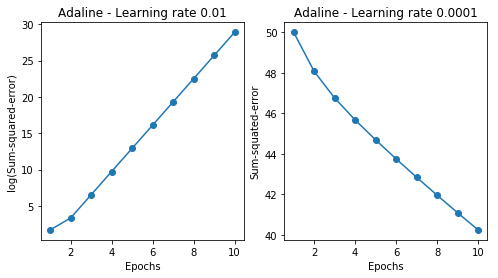

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker="o")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("log(Sum-squared-error)")
ax[0].set_title("Adaline - Learning rate 0.01")

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker="o")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Sum-squated-error")
ax[1].set_title("Adaline - Learning rate 0.0001")
plt.show()

上面两个图表示，当学习率较小的时候，成本函数减少的比较版，优化的比较慢。
而学习率比较大的话却导致了优化发散，跳过了最优点。最终导致误差越优化越差。

### 标准化
将数据进行标准化在进行训练。

In [7]:
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

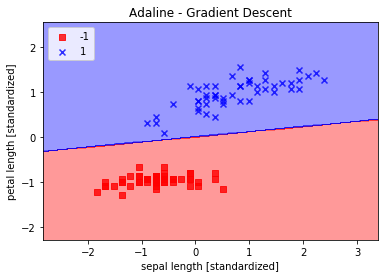

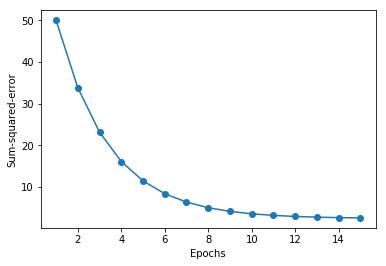

In [8]:
from util import plot_decision_regions

ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)
plot_decision_regions(X_std, y, classifier=ada)
plt.title("Adaline - Gradient Descent")
plt.xlabel("sepal length [standardized]")
plt.ylabel("petal length [standardized]")
plt.legend(loc="upper left")
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker="o")
plt.xlabel("Epochs")
plt.ylabel("Sum-squared-error")
plt.show()

### 算法优化--适应大批量数据
使用Minibatch方法优化训练方法。

In [14]:
from numpy.random import seed

class AdalineSGD(object):
    """ADAptive LInear NEuron classifier
    Parameters
    ------------
    eta : float
        Learning rate 
    n_iter : int
        Passes over the traning dataset.
    
    Attributes
    ------------
    w_ : id-array
        Weights after fitting
    errors_ : list
        Numbers of misclassifications in every epoch.
    shuffle : bool (Default : True)
        Shuffles training data every epoch.
        if True to prevent cycles.
    random_state : int (default : None)
        Set random state for shuffling
        and initializing the weights.
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
    
    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost)/len(y)
            self.cost_.append(avg_cost)
        return self
    
    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized :
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self
    
    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to zeros"""
        self.w_ = np.zeros(1 + m)
        self.w_initialized = True
    
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.net_input(xi)
        error = target - output
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error ** 2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        return self.net_input(X)
    
    def predict(self, X):
        return np.where(self.activation(X) >= 0.0, 1, -1)

### 训练与可视化

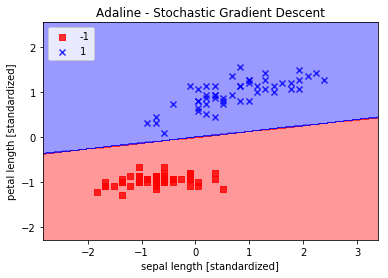

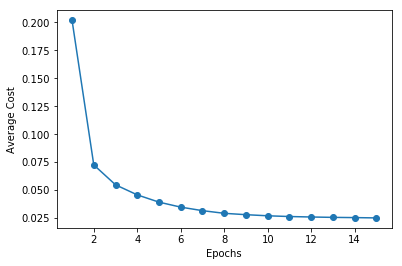

In [15]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(X_std, y)
plot_decision_regions(X_std, y, classifier=ada)
plt.title("Adaline - Stochastic Gradient Descent")
plt.xlabel("sepal length [standardized]")
plt.ylabel("petal length [standardized]")
plt.legend(loc="upper left")
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker="o")
plt.xlabel("Epochs")
plt.ylabel("Average Cost")
plt.show()